<div style="text-align:center;">
    <h1>Data-driven Estimation of Pharmacological Prescription Duration using Python</h1>
    <h3>Assignment 3 - Implementation and EDA</h3>
    <h4>Authors:</h4>
    <ul style="list-style:none;">
        <li>👤 Elgen Mar Arinasa</li>
        <li>👤 Shawn Jurgen Mayol</li>
    </ul>
    <hr>
</div>


<h2 style="color:#4B0082;">📖 Introduction</h2>
<p>
    Accurate estimation of prescription durations is critical in pharmacoepidemiological research, directly affecting assessments of medication adherence, clinical efficacy, and overall patient safety. Traditional methods often struggle with incomplete or imprecise data, necessitating innovative, data-driven approaches such as the Sessa Empirical Estimator (SEE). According to recent studies (e.g., Sessa et al., 2024; Carracedo-Martinez et al., 2022), clustering techniques like K-Means and DBSCAN significantly improve the robustness and accuracy of prescription duration estimation by identifying naturally occurring medication usage patterns.

    In this notebook, leveraging insights from these research papers, especially around data scaling necessity due to distribution skewness and varying magnitudes in dosage data, we perform comprehensive preprocessing and exploratory data analysis on the provided dataset (medeventsATC.csv). Subsequently, we apply clustering techniques within the SEE framework, critically compare their performance, and offer detailed conclusions that highlight their methodological strengths and limitations.
</p>


<h2 style="color:#4B0082;">🎯 Objectives</h2>
<p>This notebook aims to accomplish the following tasks comprehensively:</p>
<ol>
    <li><strong>Load and inspect</strong> the provided dataset for preliminary insights.</li>
    <li><strong>Clean and preprocess</strong> the dataset to prepare for robust analysis.</li>
    <li>Conduct thorough <strong>Exploratory Data Analysis (EDA)</strong> to understand data patterns and distributions clearly.</li>
    <li><strong>Implement</strong> the <em>Sessa Empirical Estimator (SEE)</em> using <strong>K-Means clustering</strong>.</li>
    <li><strong>Implement</strong> the <em>Sessa Empirical Estimator (SEE)</em> using <strong>DBSCAN clustering</strong> as an alternative approach.</li>
    <li><strong>Perform comparative analyses and visualizations</strong> to evaluate and interpret the effectiveness of both clustering techniques.</li>
    <li><strong>Provide comprehensive conclusions, insights, and a detailed discussion</strong> of findings, highlighting the strengths and weaknesses of the clustering methodologies used.</li>
</ol>


<h2 style="color:#4B0082;">📚 Import Required Libraries</h2>
<p>We begin by importing all necessary libraries for data handling, visualization, and machine learning.</p>


In [40]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import os


### 📝 Column Name Mapping (R → Python):

- **pnr** (R) → **PATIENT_ID** (Python)
- **eksd** (R) → **DATE** (Python)
- **ATC** (R) → **CATEGORY** (Python)
- **dur_original** (R) → **DURATION** (Python)
- **perday** (R) → **PERDAY**  (Python)

### ⚠️ Clarification on CATEGORY Columns:

In the original simplified R implementation, medications were represented by a single categorical column called `ATC`. In this dataset, medications are categorized at three hierarchical levels:

- **CATEGORY** (Specific ATC medication codes)
- **CATEGORY_L1** (Broader medication group)
- **CATEGORY_L2** (Detailed medication subgroup)

For clustering and SEE estimation methods (K-Means and DBSCAN), **CATEGORY** (ATC codes) was chosen as it directly parallels the original `ATC` column in the R example.



<h2 style="color:#4B0082;">📂 Data Loading and Initial Inspection</h2>
<p>First, we load the provided dataset and perform basic inspection to understand its structure and contents.</p>


In [41]:
import pandas as pd

# Load dataset
data = pd.read_csv('medeventsATC.csv')

# Quick inspection
print("Dataset Dimensions:", data.shape)
data.head()


Dataset Dimensions: (1564, 7)


,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
0,1,2057-09-04,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
1,1,2058-06-03,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
2,1,2058-07-09,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
3,1,2056-10-09,41.666667,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"
4,1,2056-12-10,40.000000,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"


<h2 style="color:#4B0082;">🛠️ Data Preprocessing</h2>
<p>We preprocess the data by handling missing values, converting date formats, and ensuring correct data types.</p>


In [42]:
# Check for missing values
missing_data = data.isnull().sum()
print(missing_data)

# Convert DATE column to datetime
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

# Drop critical missing entries
data.dropna(subset=['PATIENT_ID', 'DATE', 'DURATION', 'CATEGORY'], inplace=True)

# Verify data types after cleaning
data.info()


PATIENT_ID     0
DATE           0
DURATION       0
PERDAY         0
CATEGORY       0
CATEGORY_L1    0
CATEGORY_L2    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   PATIENT_ID   1564 non-null   int64         
 1   DATE         1564 non-null   datetime64[ns]
 2   DURATION     1564 non-null   float64       
 3   PERDAY       1564 non-null   float64       
 4   CATEGORY     1564 non-null   object        
 5   CATEGORY_L1  1564 non-null   object        
 6   CATEGORY_L2  1564 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 85.7+ KB


 <h4> Detailed statistics for Dosage Per Day </h4>

In [43]:
# Detailed statistics for Dosage Per Day
data['PERDAY'].describe()


count    1.564000e+03
mean     1.079554e+05
std      3.688593e+05
min      6.666667e-02
25%      1.000000e+02
50%      6.000000e+02
75%      3.333333e+03
max      8.000000e+06
Name: PERDAY, dtype: float64

 <h4>Detailed statistics for Medication Duration</h4>

In [44]:
# Detailed statistics for Medication Duration
data['DURATION'].describe()

count    1564.000000
mean       38.339786
std        33.581154
min         2.000000
25%        28.000000
50%        30.000000
75%        35.377358
max       400.000000
Name: DURATION, dtype: float64

<h2 style="color:#4B0082;">🔍 Exploratory Data Analysis (EDA)</h2>
<p>
    The purpose of EDA is to discover patterns, detect anomalies, and validate data assumptions through statistical summaries and visualizations.
</p>


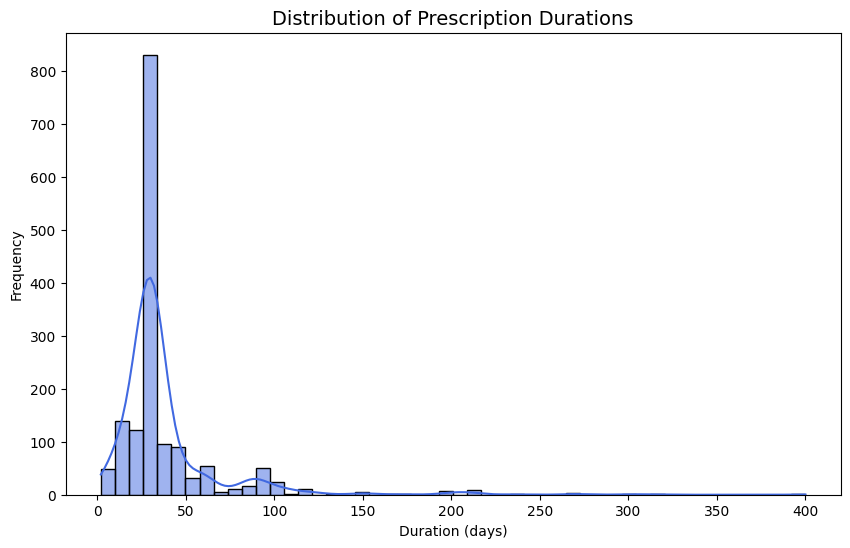

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(data['DURATION'], bins=50, kde=True, color='royalblue')
plt.title('Distribution of Prescription Durations', fontsize=14)
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()


<h2 style="color:#4B0082;">Visualization: Distribution of Medication Dosage (PERDAY): </h2>

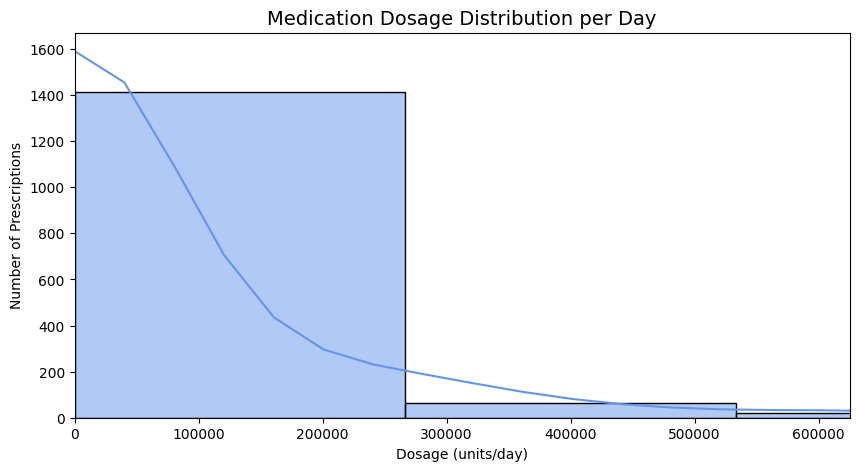

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(data['PERDAY'], bins=30, kde=True, color='cornflowerblue')
plt.title('Medication Dosage Distribution per Day', fontsize=14)
plt.xlabel('Dosage (units/day)')
plt.ylabel('Number of Prescriptions')
plt.xlim(0, data['PERDAY'].quantile(0.95))  # limited to 95th percentile for better visualization
plt.show()


<h4>📊 Trend Analysis of Medication Prescriptions Over Time (Yearly) </h4>

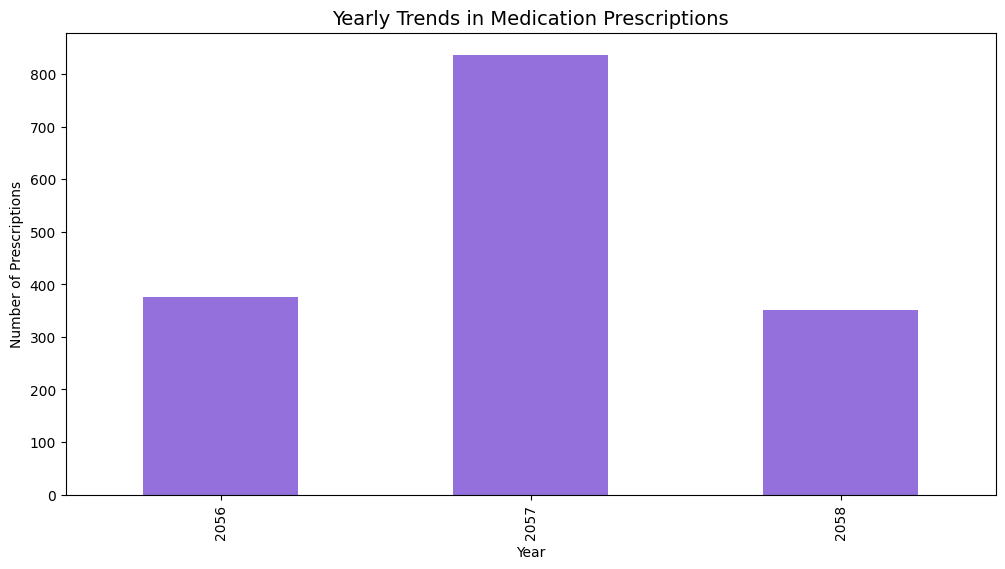

In [47]:
data['DATE'] = pd.to_datetime(data['DATE'])
plt.figure(figsize=(12, 6))
data['DATE'].dt.year.value_counts().sort_index().plot(kind='bar', color='mediumpurple')
plt.title('Yearly Trends in Medication Prescriptions', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Prescriptions')
plt.show()


<h2>✅ Visualizing CATEGORY (Detailed Categories):</h2>

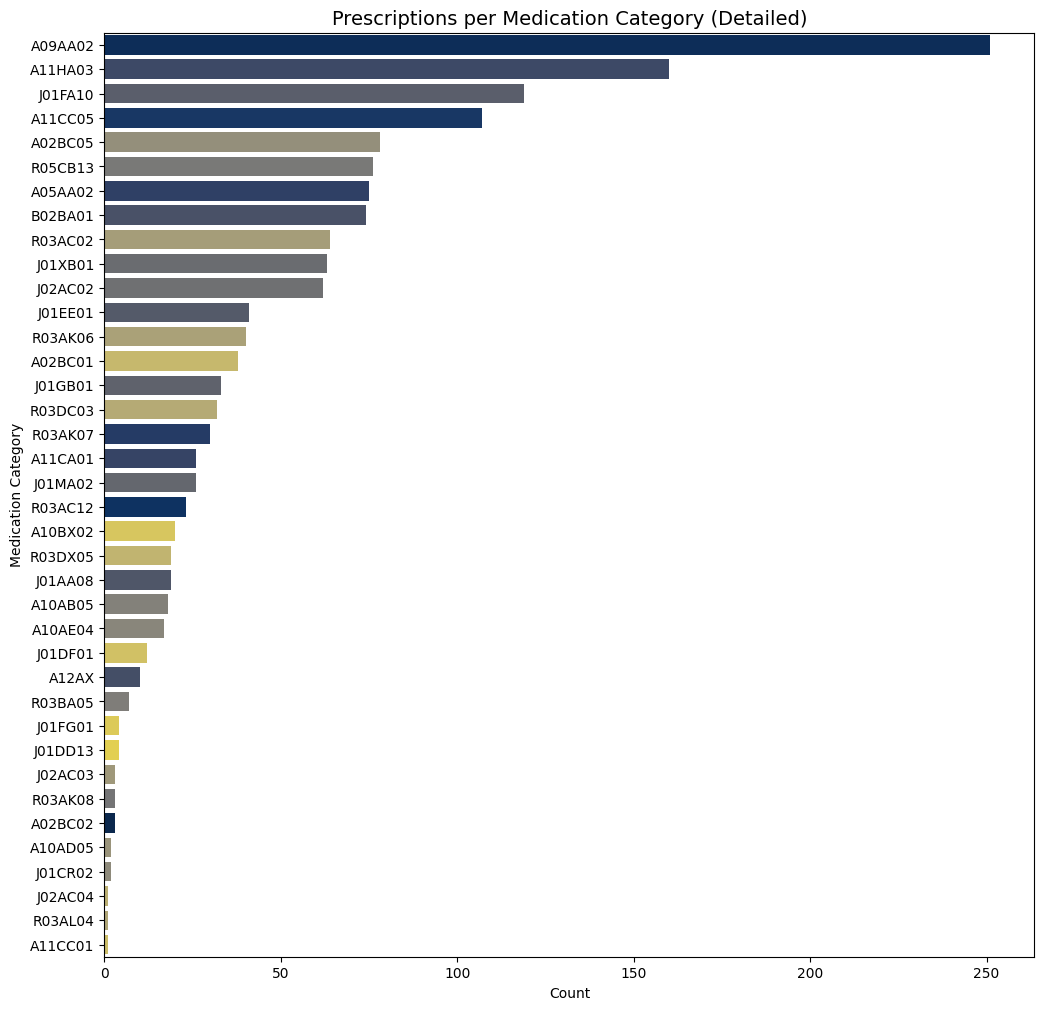

In [48]:
plt.figure(figsize=(12, 12))
sns.countplot(y='CATEGORY', data=data, 
              order=data['CATEGORY'].value_counts().index, 
              hue='CATEGORY', palette='cividis', legend=False)
plt.title('Prescriptions per Medication Category (Detailed)', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Medication Category')
plt.show()


<h3 style="color:#00008B;">💊 Prescription Counts by Medication Category (CATEGORY_L1)</h3>
<p>Analyzing prescription frequency by primary medication category to understand prescription trends.</p>


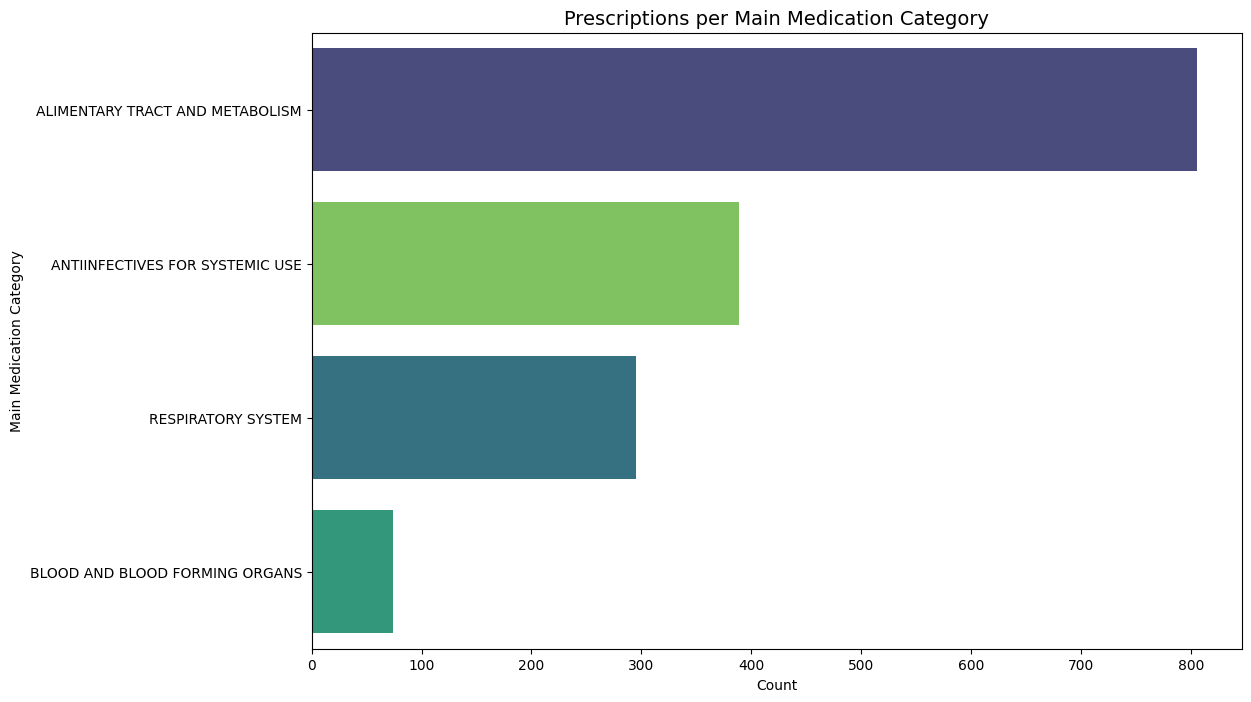

In [49]:
plt.figure(figsize=(12, 8))
sns.countplot(y='CATEGORY_L1', data=data, 
              order=data['CATEGORY_L1'].value_counts().index, 
              hue='CATEGORY_L1', palette='viridis', legend=False)
plt.title('Prescriptions per Main Medication Category', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Main Medication Category')
plt.show()


<h3 style="color:#00008B;">✅ Visualizing CATEGORY_L2 (Subcategories):</h3>

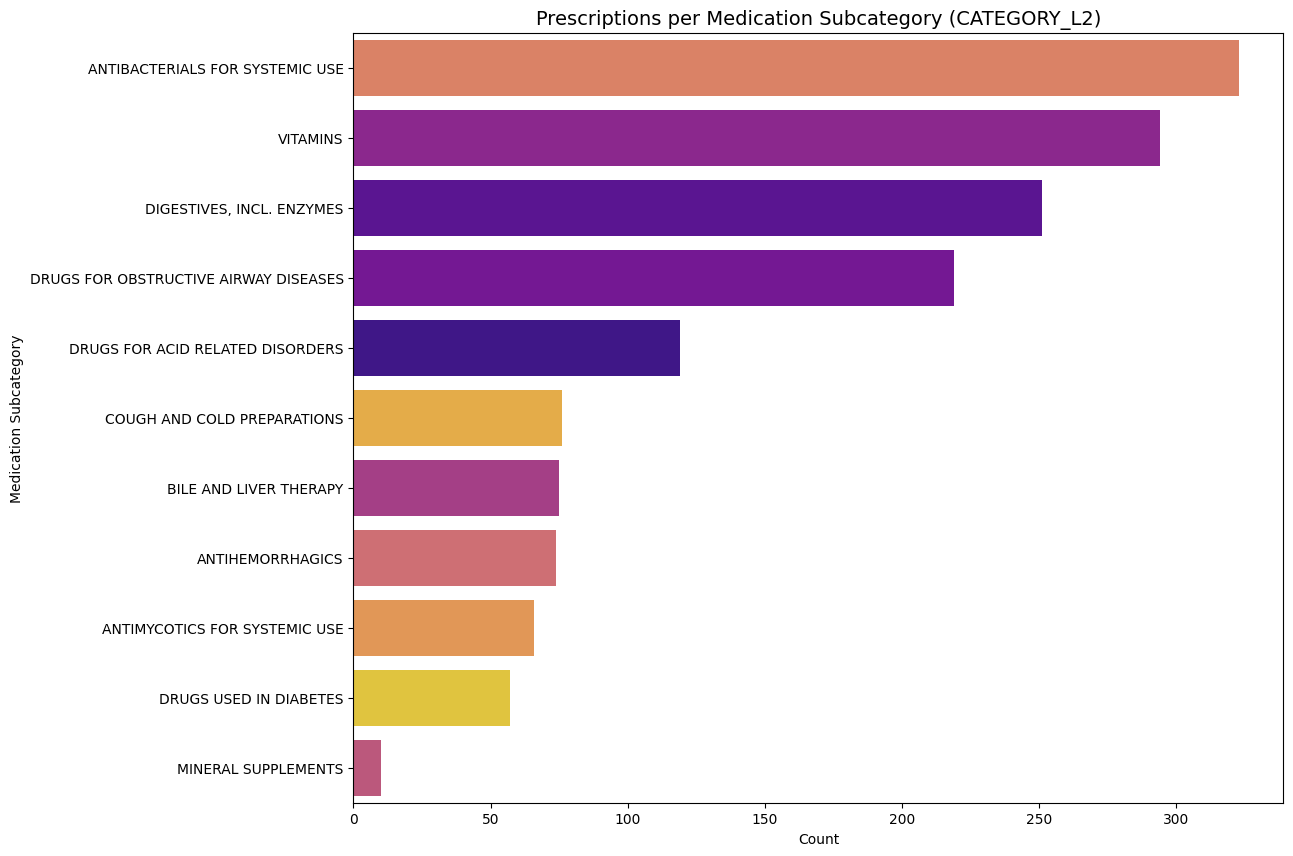

In [50]:
plt.figure(figsize=(12, 10))
sns.countplot(y='CATEGORY_L2', data=data, 
              order=data['CATEGORY_L2'].value_counts().index, 
              hue='CATEGORY_L2', palette='plasma', legend=False)
plt.title('Prescriptions per Medication Subcategory (CATEGORY_L2)', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Medication Subcategory')
plt.show()


<h3 style="color:#00008B;">📅 Temporal Patterns of Prescriptions</h3>
<p>Examining monthly trends to detect seasonal patterns or temporal shifts in prescription frequency.</p>


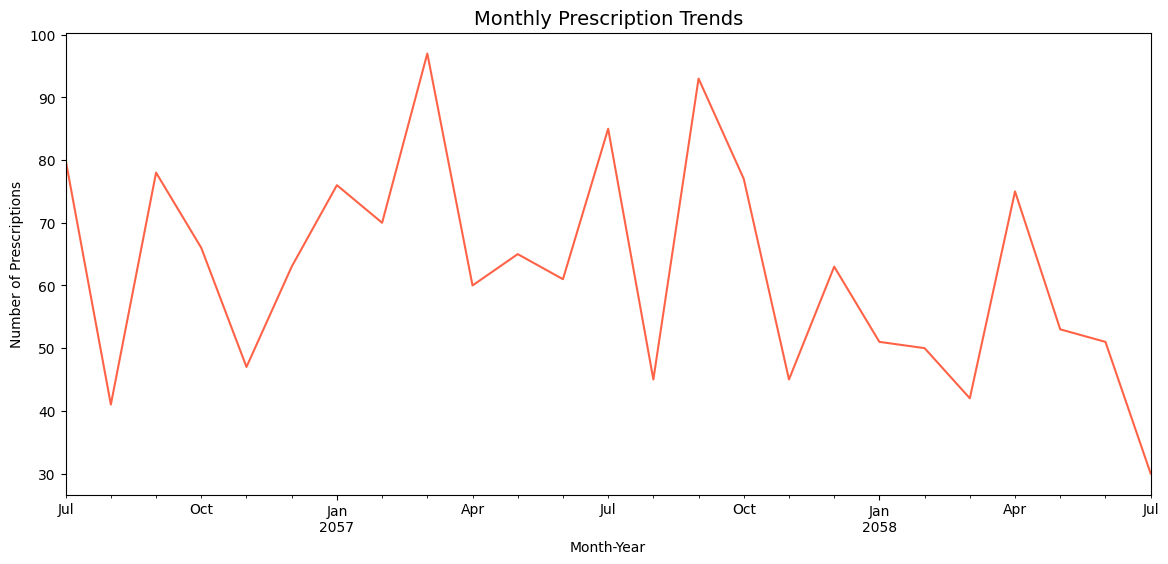

In [51]:
# Set date as index for temporal analysis
data.set_index('DATE', inplace=True)

# Monthly prescription counts
monthly_prescriptions = data.resample('M').size()

# Plotting the temporal trend
plt.figure(figsize=(14,6))
monthly_prescriptions.plot(color='tomato')
plt.title('Monthly Prescription Trends', fontsize=14)
plt.xlabel('Month-Year')
plt.ylabel('Number of Prescriptions')
plt.show()

# Resetting index for further analysis
data.reset_index(inplace=True)


<h3 style="color:#00008B;">🧑‍🤝‍🧑 Patient-Level Prescription Patterns</h3>
<p>Investigating how prescription behavior varies among patients, focusing on the number of prescriptions per individual.</p>


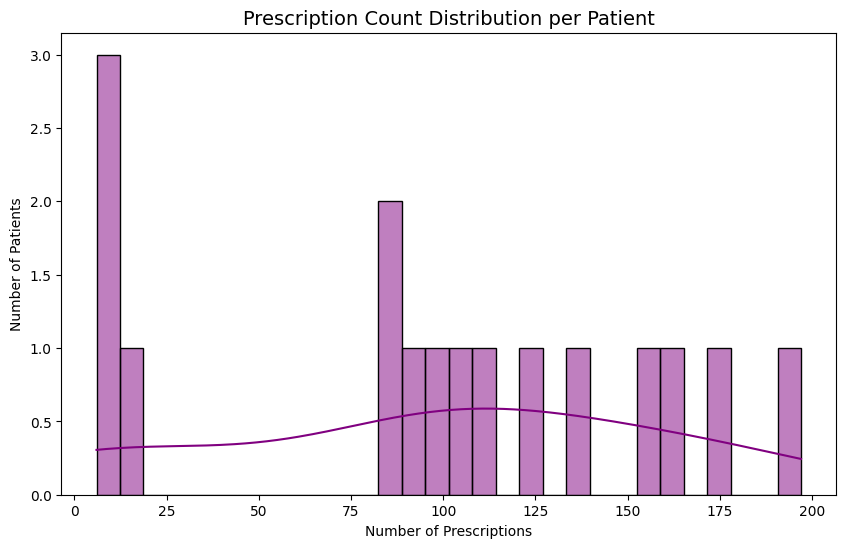

In [52]:
# Number of prescriptions per patient
patient_counts = data['PATIENT_ID'].value_counts()

# Plot distribution
plt.figure(figsize=(10,6))
sns.histplot(patient_counts, bins=30, kde=True, color='purple')
plt.title('Prescription Count Distribution per Patient', fontsize=14)
plt.xlabel('Number of Prescriptions')
plt.ylabel('Number of Patients')
plt.show()


<h3 style="color:#00008B;">🔗 Correlation Analysis</h3>
<p>Identifying correlations between numerical features such as prescription duration and dosage per day.</p>


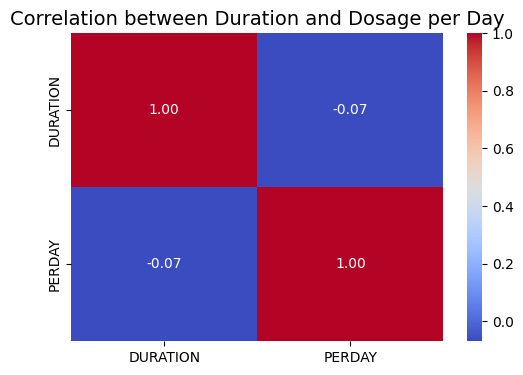

In [53]:
corr_matrix = data[['DURATION', 'PERDAY']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Duration and Dosage per Day', fontsize=14)
plt.show()


<h3 style="color:#00008B;">🚨 Outlier Detection in Prescription Duration</h3>
<p>Using boxplots to visualize and detect potential outliers that could impact clustering accuracy.</p>


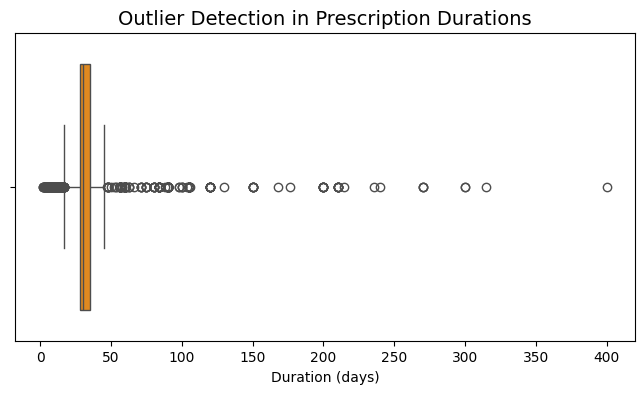

count    1564.000000
mean       38.339786
std        33.581154
min         2.000000
25%        28.000000
50%        30.000000
75%        35.377358
max       400.000000
Name: DURATION, dtype: float64

In [54]:
plt.figure(figsize=(8,4))
sns.boxplot(x=data['DURATION'], color='darkorange')
plt.title('Outlier Detection in Prescription Durations', fontsize=14)
plt.xlabel('Duration (days)')
plt.show()

data['DURATION'].describe()


<h2>🚨 Additional Outlier Detection (Boxplots) </h2>

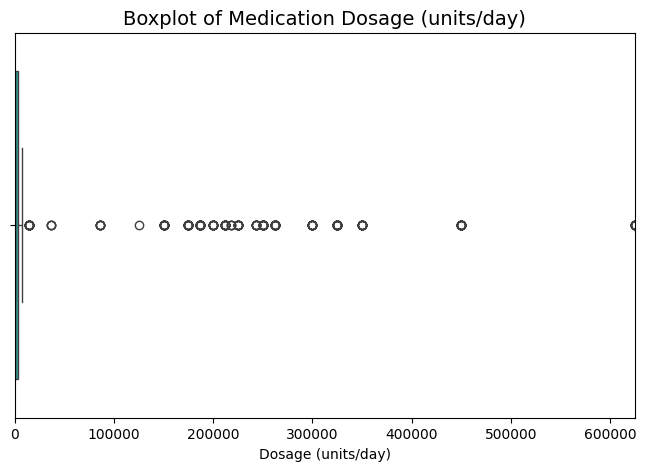

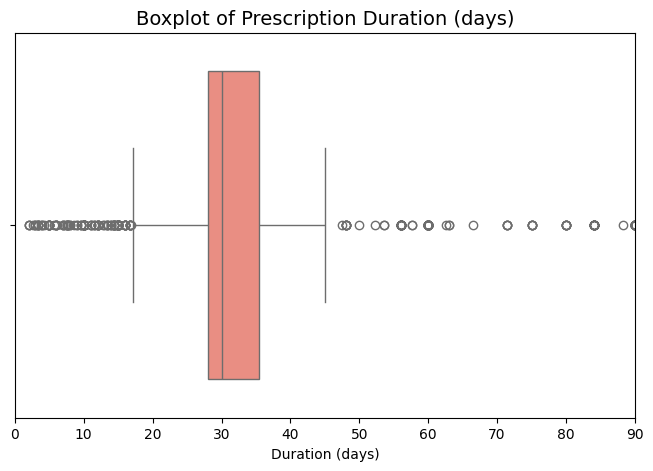

In [55]:
# Outlier Detection for Dosage per Day
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['PERDAY'], color='lightseagreen')
plt.title('Boxplot of Medication Dosage (units/day)', fontsize=14)
plt.xlabel('Dosage (units/day)')
plt.xlim(0, data['PERDAY'].quantile(0.95))
plt.show()

# Outlier Detection for Prescription Duration
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['DURATION'], color='salmon')
plt.title('Boxplot of Prescription Duration (days)', fontsize=14)
plt.xlabel('Duration (days)')
plt.xlim(0, data['DURATION'].quantile(0.95))
plt.show()


<h2 style="color:#4B0082;">📌 EDA Summary and Insights</h2>
<ul>
    <li>Prescription durations show a wide distribution, indicating diverse prescribing behaviors.</li>
    <li>Dominant medication categories suggest targeted areas for further analysis.</li>
    <li>Clear temporal trends and distinct patient-level prescription patterns provide valuable insights for subsequent clustering analysis.</li>
</ul>
<p>These results provide the groundwork needed for implementing the Sessa Empirical Estimator (SEE) using K-Means and DBSCAN in the subsequent notebook sections.</p>


<h2 style="color:#03208B;">⚙️ Implementation of Sessa Empirical Estimator (SEE) with K-Means</h2>

<h4>Step 1: Feature Scaling (Essential due to Skewness and Magnitude Variation)<h4>

In [138]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['DURATION', 'PERDAY']])


<h4> Step 2: Implementing K-Means Clustering </h4>

In [141]:
kmeans = KMeans(n_clusters=3, random_state=1234, n_init=10)
clusters_kmeans = kmeans.fit_predict(scaled_features)
data['KMeans_Cluster'] = clusters_kmeans


<h4> Step 3: Visualizing K-Means Clusters</h4>

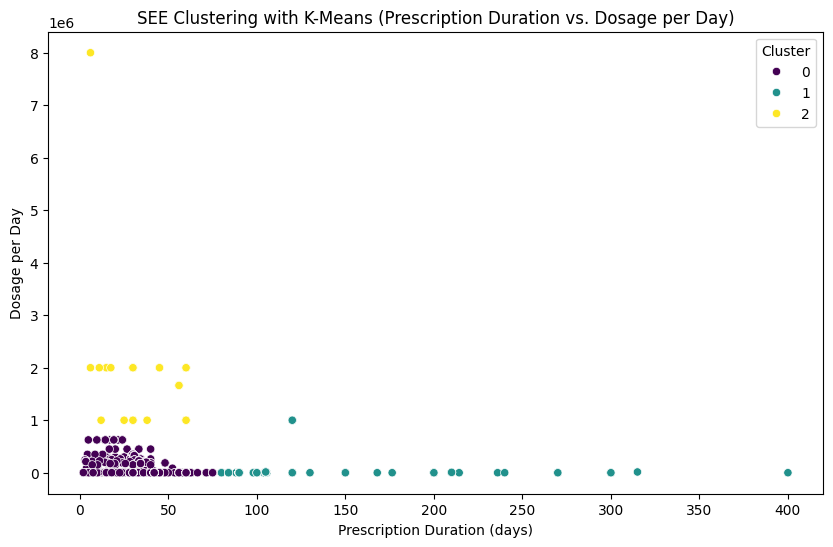

In [142]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DURATION', y='PERDAY', data=data, hue='KMeans_Cluster', palette='viridis')
plt.title('SEE Clustering with K-Means (Prescription Duration vs. Dosage per Day)')
plt.xlabel('Prescription Duration (days)')
plt.ylabel('Dosage per Day')
plt.legend(title='Cluster')
plt.show()


<h2 style="color:#03208B;">⚙️ Implementation of SEE with DBSCAN Clustering</h2>

<h4> Step 1: DBSCAN Implementation </h4>

In [215]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters_dbscan = dbscan.fit_predict(scaled_features)
data['DBSCAN_Cluster'] = clusters_dbscan 


 <h4> Step 2: Visualizing DBSCAN Clusters </h4>

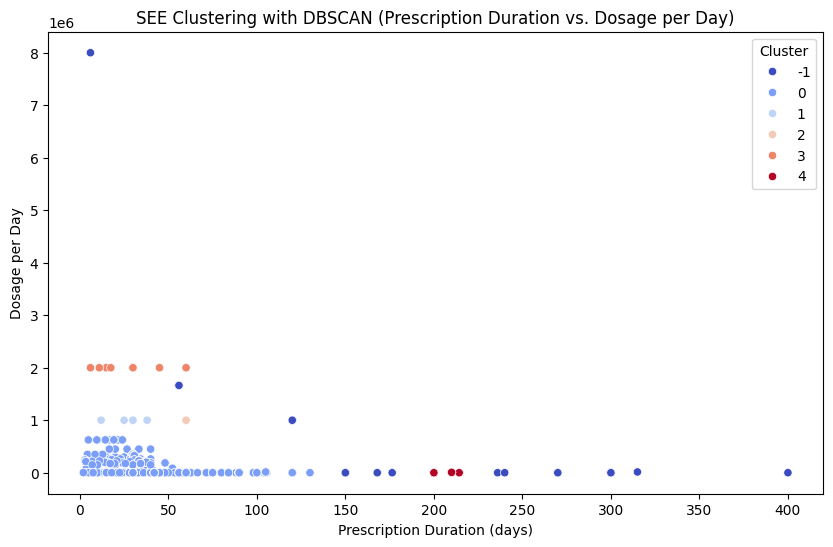

In [216]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DURATION', y='PERDAY', data=data, hue='DBSCAN_Cluster', palette='coolwarm')
plt.title('SEE Clustering with DBSCAN (Prescription Duration vs. Dosage per Day)')
plt.xlabel('Prescription Duration (days)')
plt.ylabel('Dosage per Day')
plt.legend(title='Cluster')
plt.show()


In [284]:
print(data['DBSCAN_Cluster'].value_counts())


DBSCAN_Cluster
 0    1469
 3      25
-1      24
 1      21
 4      15
 2      10
Name: count, dtype: int64


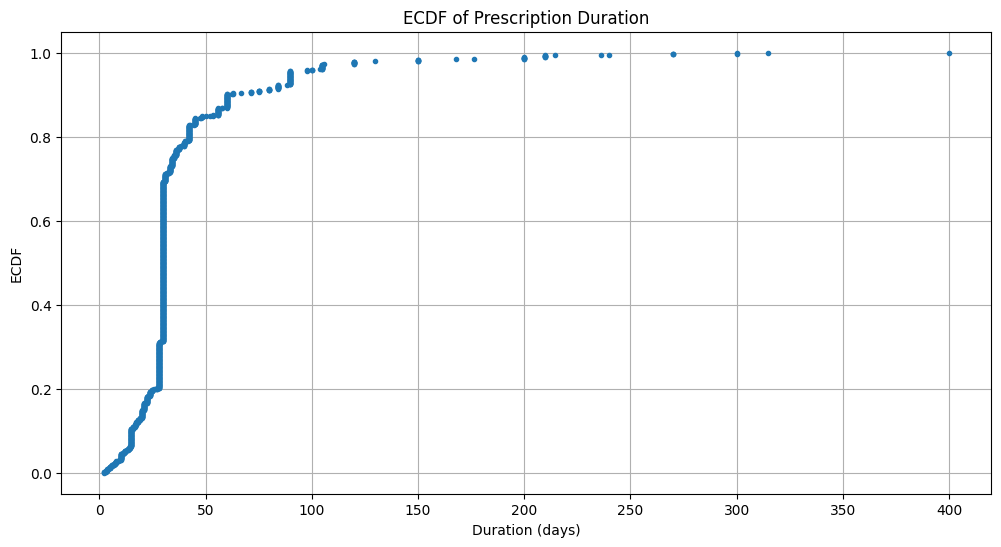

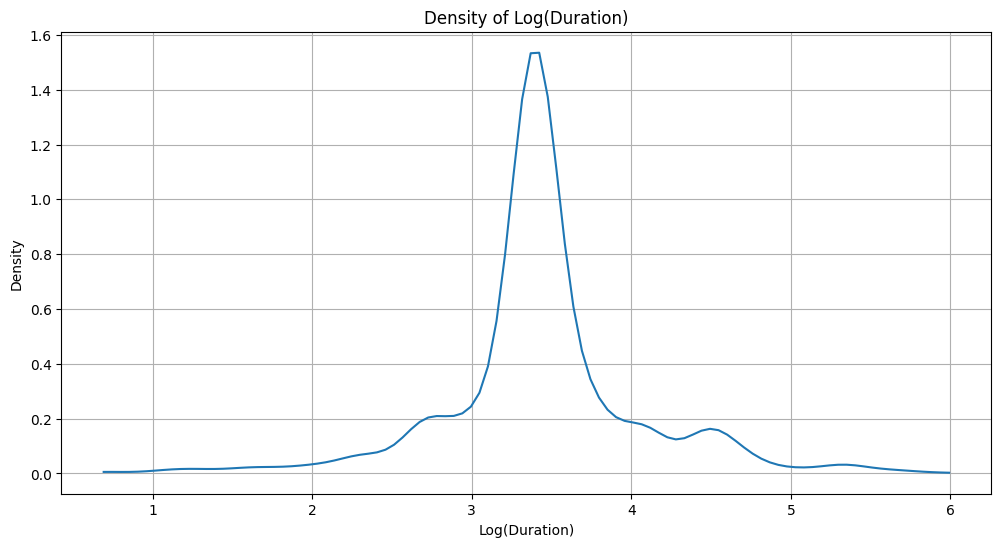

In [71]:
# ECDF Plot
from statsmodels.distributions.empirical_distribution import ECDF
intervals = data['DURATION']
ecdf = ECDF(intervals)

plt.figure(figsize=(12, 6))
plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.title('ECDF of Prescription Duration')
plt.xlabel('Duration (days)')
plt.ylabel('ECDF')
plt.grid()
plt.show()

# Density plot (log scale)
import numpy as np
from scipy.stats import gaussian_kde

log_intervals = np.log(intervals[intervals > 0])
density = gaussian_kde(log_intervals)
xs = np.linspace(min(log_intervals), max(log_intervals), 100)

plt.figure(figsize=(12, 6))
plt.plot(xs, density(xs))
plt.title('Density of Log(Duration)')
plt.xlabel('Log(Duration)')
plt.ylabel('Density')
plt.grid()
plt.show()


In [97]:
# scaled_features = StandardScaler().fit_transform(data[['PERDAY', 'DURATION']])

# # K-Means Clustering
# kmeans = KMeans(n_clusters=3, random_state=42)
# data['kmeans_labels'] = kmeans.fit_predict(scaled_features)

# # DBSCAN Clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# data['dbscan_labels'] = dbscan.fit_predict(scaled_features)

# # Compute scores
# kmeans_score = silhouette_score(scaled_features, data['kmeans_labels'])
# dbscan_score = silhouette_score(scaled_features, data['dbscan_labels'])

# comparison_df = pd.DataFrame({
#     'Clustering Method': ['K-Means', 'DBSCAN'],
#     'Silhouette Score': [kmeans_score, dbscan_score]
# })

# sns.barplot(x='Clustering Method', y='Silhouette Score', data=comparison_df, palette='magma')
# plt.title('Clustering Methods Comparison (My Dataset)')
# plt.xlabel('Clustering Method')
# plt.ylabel('Silhouette Score (Higher is Better)')
# plt.show()


<h2> Callable Functions</h2>
<h3> 🟢 1. SEE_KMeans (Python Callable Function) </h3>
    <h4 style="color:#03208B;"> <b> Interpreting the ECDF (Empirical Cumulative Distribution Function) </b> </h4>
Why we have 80% ECDF and 100% ECDF. 

     ECDF (Empirical CDF) measures cumulative probability distribution over time intervals.
The 80% ECDF focuses on the lower 80% of intervals (removes extreme high values).
The 100% ECDF includes all values (shows full distribution).
Why Keep Only 80%?
This removes the upper 20% of extreme values that may skew clustering results.
It ensures that most common refill patterns are used.

In [267]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def See_KMeans(category=None, df=None):
    if df is None:
        raise ValueError("DataFrame (df) must be provided.")

    # If a category is specified, filter it; otherwise, use the full dataset
    df_category = df[df['CATEGORY'] == category].copy() if category else df.copy()

    df_category.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    df_category['prev_DATE'] = df_category.groupby('PATIENT_ID')['DATE'].shift(1)
    df_category.dropna(subset=['prev_DATE'], inplace=True)

    df_category['event_interval'] = (df_category['DATE'] - df_category['prev_DATE']).dt.days

    # ECDF Calculation
    sorted_intervals = np.sort(df_category['event_interval'].values)
    n = len(sorted_intervals)
    yvals = np.arange(1, n+1) / n
    ecdf_df = pd.DataFrame({'interval_days': sorted_intervals, 'ecdf': yvals})

    # Keep 80% ECDF
    ecdf_80_df = ecdf_df[ecdf_df['ecdf'] <= 0.8].copy()
    ni_max = ecdf_80_df['interval_days'].max()

    # K-Means Clustering
    scaled_data = StandardScaler().fit_transform(ecdf_df[['interval_days']])
    kmeans = KMeans(n_clusters=3, random_state=1234, n_init=10)
    ecdf_df['cluster'] = kmeans.fit_predict(scaled_data)

    # **Retain CATEGORY Column** ✅
    ecdf_df['CATEGORY'] = df_category['CATEGORY'].values[:len(ecdf_df)]

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(ecdf_80_df['interval_days'], ecdf_80_df['ecdf'])
    axs[0].set_title(f"80% ECDF (Interval ≤ {ni_max} days)")
    axs[1].scatter(ecdf_df['interval_days'], ecdf_df['ecdf'])
    axs[1].set_title("100% ECDF")
    plt.tight_layout()
    plt.show()

    return ecdf_df  # Returns the clustered DataFrame

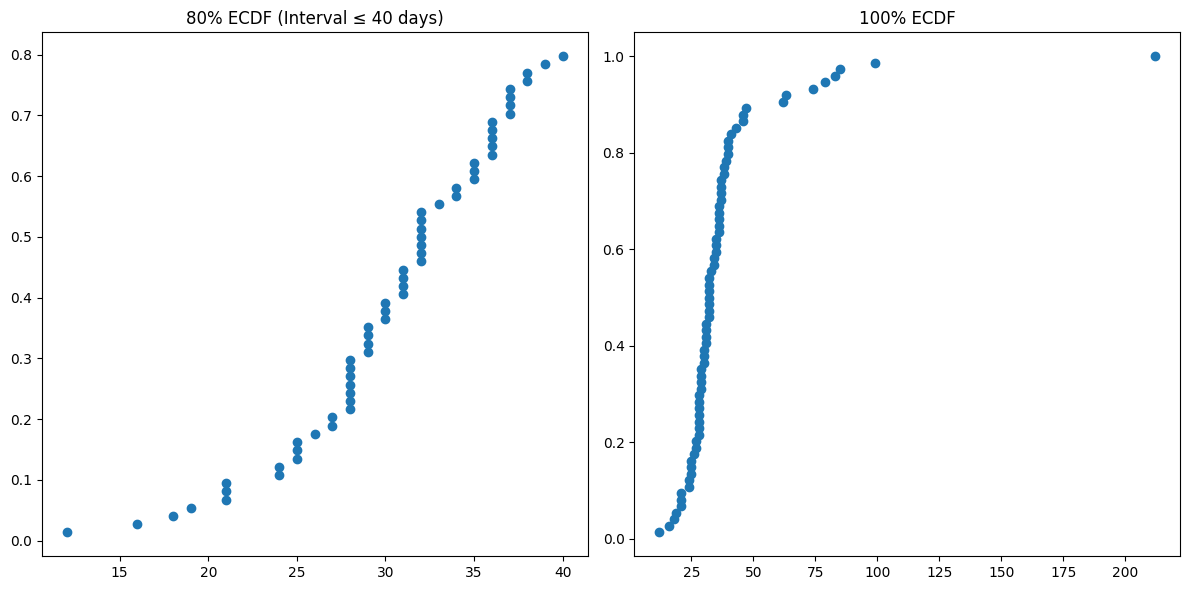

,interval_days,ecdf,cluster,CATEGORY
0,12,0.013514,0,A02BC05
1,16,0.027027,0,A02BC05
2,18,0.040541,0,A02BC05
3,19,0.054054,0,A02BC05
4,21,0.067568,0,A02BC05


In [268]:
see_kmeans_result = See_KMeans('A02BC05', data)
see_kmeans_result.head()


<h2> Callable Functions </h2>
<h3> 🟢 2. SEE_DBSCAN (Python Callable Function) </h3>

In [269]:
def See_DBSCAN(category=None, df=None):
    if df is None:
        raise ValueError("DataFrame (df) must be provided.")

    # If a category is specified, filter it; otherwise, use the full dataset
    df_category = df[df['CATEGORY'] == category].copy() if category else df.copy()

    df_category.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    df_category['prev_DATE'] = df_category.groupby('PATIENT_ID')['DATE'].shift(1)
    df_category.dropna(subset=['prev_DATE'], inplace=True)

    df_category['event_interval'] = (df_category['DATE'] - df_category['prev_DATE']).dt.days

    # ECDF Calculation
    sorted_intervals = np.sort(df_category['event_interval'].values)
    n = len(sorted_intervals)
    yvals = np.arange(1, n+1) / n
    ecdf_df = pd.DataFrame({'interval_days': sorted_intervals, 'ecdf': yvals})

    # Keep 80% ECDF
    ecdf_80_df = ecdf_df[ecdf_df['ecdf'] <= 0.8].copy()
    ni_max = ecdf_80_df['interval_days'].max()

    # DBSCAN Clustering
    X = ecdf_df[['interval_days']].values
    scaled_X = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    ecdf_df['cluster'] = dbscan.fit_predict(scaled_X)

    # **Retain CATEGORY Column** ✅
    ecdf_df['CATEGORY'] = df_category['CATEGORY'].values[:len(ecdf_df)]

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(ecdf_80_df['interval_days'], ecdf_80_df['ecdf'])
    axs[0].set_title(f"80% ECDF (Interval ≤ {ni_max} days)")
    axs[1].scatter(ecdf_df['interval_days'], ecdf_df['ecdf'])
    axs[1].set_title("100% ECDF")
    plt.tight_layout()
    plt.show()

    return ecdf_df  # Returns the clustered DataFrame

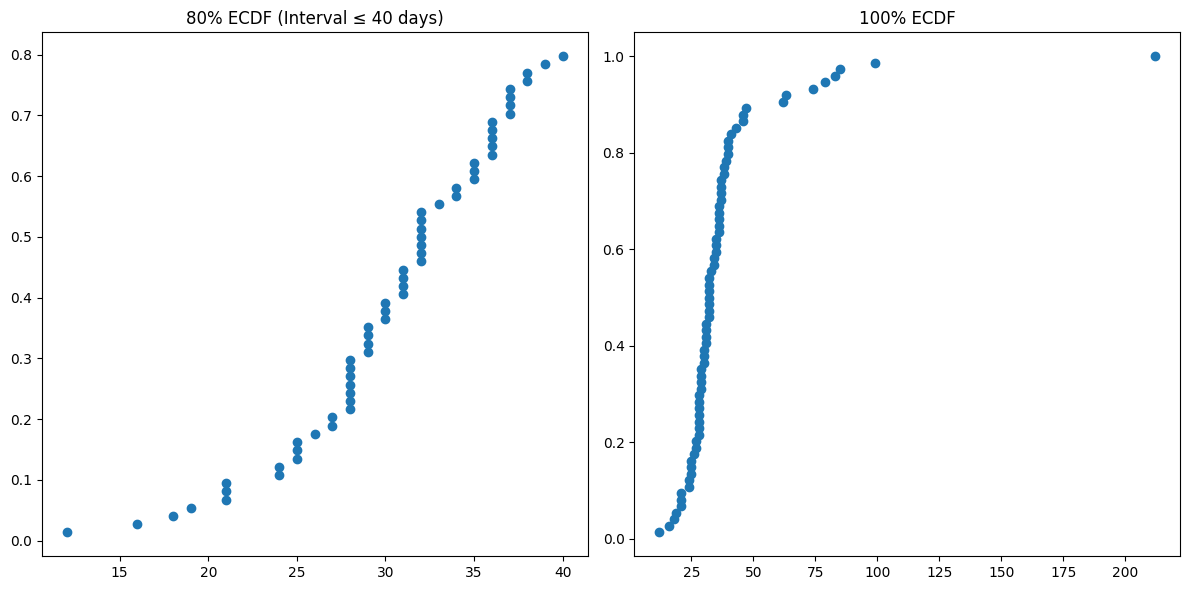

,interval_days,ecdf,cluster,CATEGORY
0,12,0.013514,0,A02BC05
1,16,0.027027,0,A02BC05
2,18,0.040541,0,A02BC05
3,19,0.054054,0,A02BC05
4,21,0.067568,0,A02BC05


In [270]:
see_dbscan_result = See_DBSCAN('A02BC05', data)
see_dbscan_result.head()


<h3> Actual Comparison for the same category </h3>

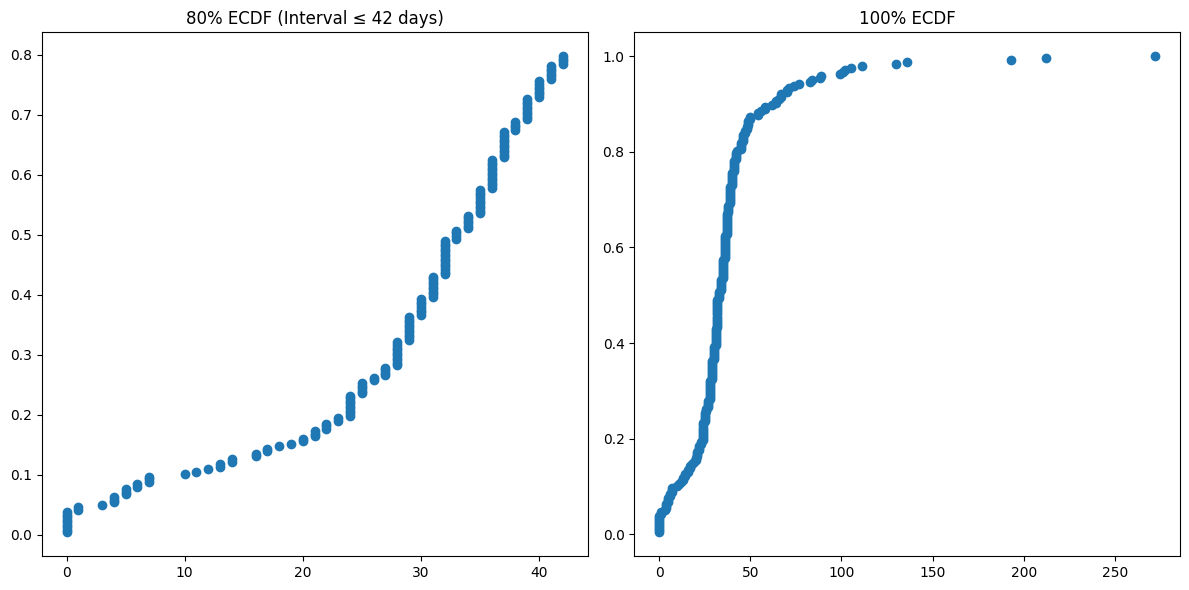

,interval_days,ecdf,cluster,CATEGORY
0,0,0.004219,0,A09AA02
1,0,0.008439,0,A09AA02
2,0,0.012658,0,A09AA02
3,0,0.016878,0,A09AA02
4,0,0.021097,0,A09AA02


In [271]:
see_kmeans_result = See_KMeans('A09AA02', data)
see_kmeans_result.head()

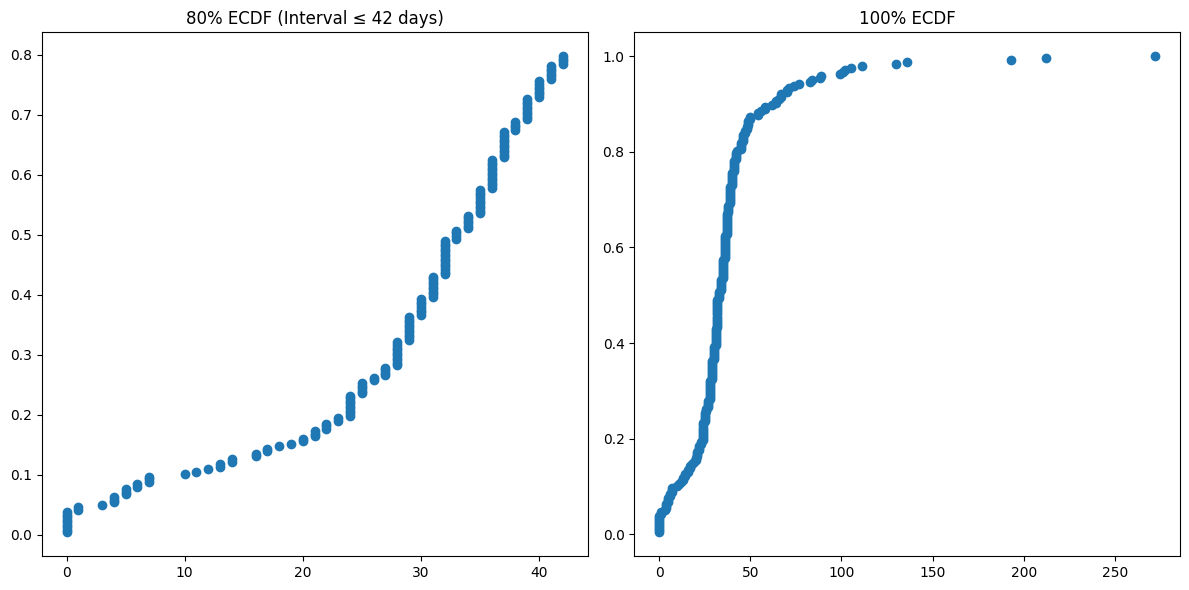

,interval_days,ecdf,cluster,CATEGORY
0,0,0.004219,0,A09AA02
1,0,0.008439,0,A09AA02
2,0,0.012658,0,A09AA02
3,0,0.016878,0,A09AA02
4,0,0.021097,0,A09AA02


In [272]:
see_dbscan_result = See_DBSCAN('A09AA02', data)
see_dbscan_result.head()


## 🟣3. SEE Assumption Function

This function analyzes the **assumptions of the Sessa Empirical Estimator (SEE)** by evaluating the **prescription refill patterns**. It calculates the **duration between consecutive prescriptions** for each patient and visualizes the trends using a **boxplot**.

**Key Steps:**
1. **Sort prescriptions by date** per patient.
2. **Compute previous prescription dates** (`prev_DATE`) for each patient.
3. **Assign prescription order numbers** (`p_number`).
4. **Calculate prescription intervals** (`Duration` in days).
5. **Generate a boxplot** to analyze refill consistency over time.

The function returns the processed dataset and **highlights median trends** across all patients.


In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def see_assumption(df_category):
    # Ensure the data is sorted properly
    df_category = df_category.sort_values(by=['PATIENT_ID', 'DATE']).copy()

    # Create previous prescription date
    df_category['prev_DATE'] = df_category.groupby('PATIENT_ID')['DATE'].shift(1)

    # Assign prescription number (starts at 1 for the first prescription)
    df_category['p_number'] = df_category.groupby('PATIENT_ID').cumcount() + 1

    # Filter only prescriptions with at least one prior prescription
    df_category = df_category[df_category['p_number'] >= 2].copy()

    # Compute duration between prescriptions
    df_category['Duration'] = (df_category['DATE'] - df_category['prev_DATE']).dt.days

    # Boxplot Visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_category)
    plt.title("Boxplot of Prescription Duration by Prescription Number (p_number)")
    plt.xlabel("Prescription Number (p_number)")
    plt.ylabel("Duration (days)")

    # Compute the overall median duration
    median_overall = df_category.groupby('PATIENT_ID')['Duration'].median().median()

    # Plot horizontal red dashed line for median duration across all patients
    plt.axhline(y=median_overall, color='red', linestyle='--', label=f'Overall Median: {median_overall:.2f} days')
    
    plt.legend()
    plt.show()

    return df_category


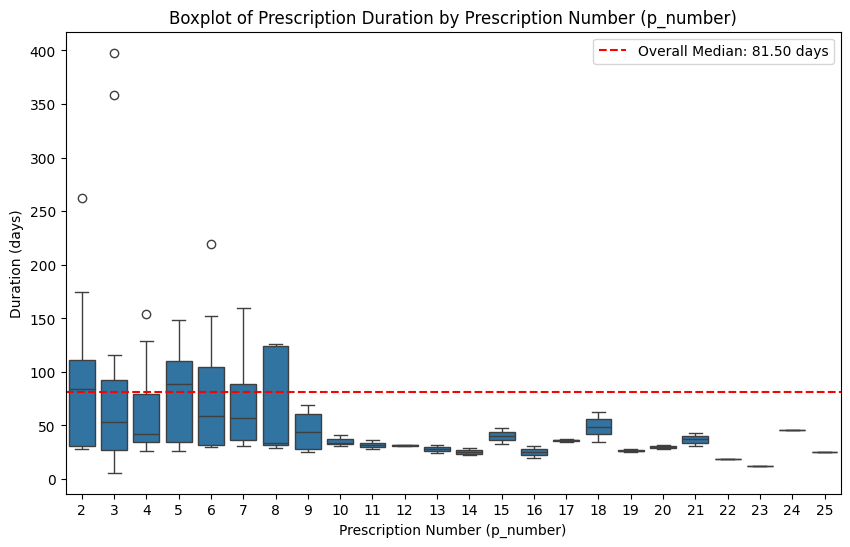

,DATE,PATIENT_ID,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2,KMeans_Cluster,DBSCAN_Cluster,Cluster,kmeans_labels,dbscan_labels,prev_DATE,p_number,Duration
14,2057-04-14,2,90.000000,1111.111111,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,1,0,1,1,0,2056-10-21,2,175
15,2058-04-07,2,90.000000,1111.111111,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,1,0,1,1,0,2057-04-14,3,358
50,2056-07-31,3,20.571429,4861.111111,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,0,0,0,0,0,2056-07-01,2,30
51,2057-09-02,3,40.000000,5000.000000,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,0,0,0,0,0,2056-07-31,3,398
156,2057-04-21,4,30.000000,3333.333333,A11CC05,ALIMENTARY TRACT AND METABOLISM,VITAMINS,0,0,0,0,0,2056-08-02,2,262


In [274]:
assumption_df = see_assumption(data[data['CATEGORY']=='A11CC05'])
assumption_df.head()


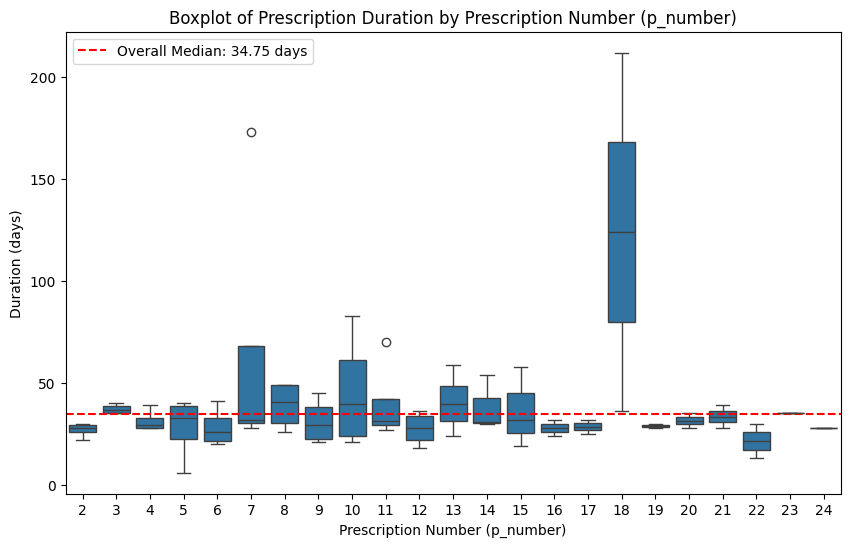

,DATE,PATIENT_ID,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2,KMeans_Cluster,DBSCAN_Cluster,Cluster,kmeans_labels,dbscan_labels,prev_DATE,p_number,Duration
26,2056-07-31,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,0,0,0,2056-07-01,2,30
27,2056-09-09,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,0,0,0,2056-07-31,3,40
28,2056-10-18,3,37.5,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,0,0,0,2056-09-09,4,39
29,2056-11-15,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,0,0,0,2056-10-18,5,28
30,2056-12-26,3,30.0,400.0,A05AA02,ALIMENTARY TRACT AND METABOLISM,BILE AND LIVER THERAPY,0,0,0,0,0,2056-11-15,6,41


In [275]:
assumption_df = see_assumption(data[data['CATEGORY']=='A05AA02'])
assumption_df.head()

<H2>Section to check out the silhouette scores comparison for the entirety of the dataset </h2>

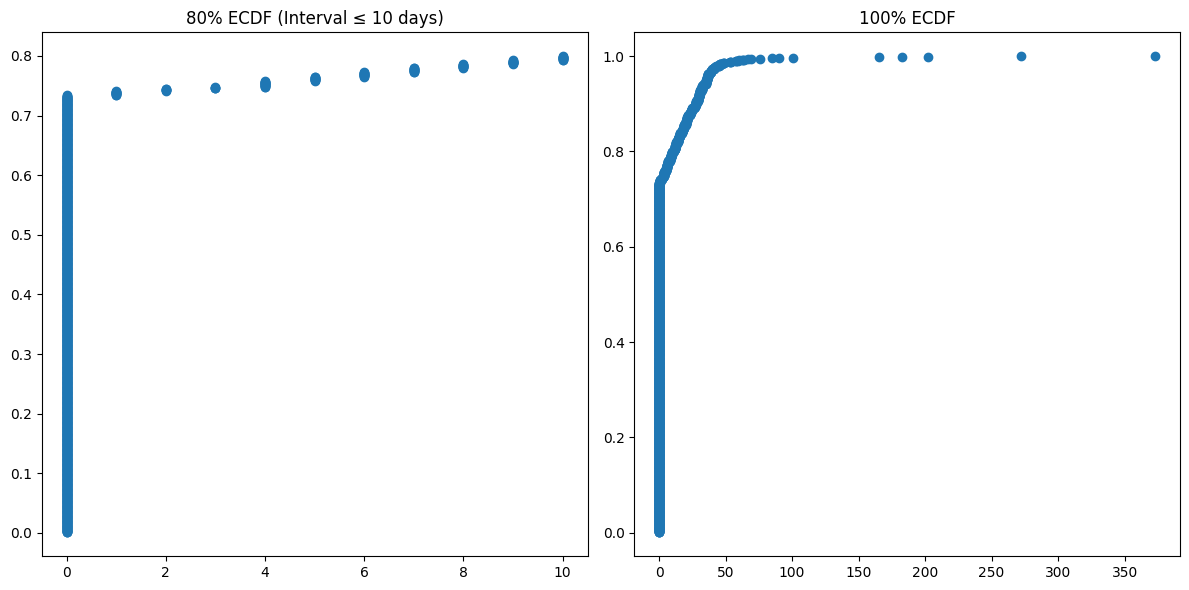

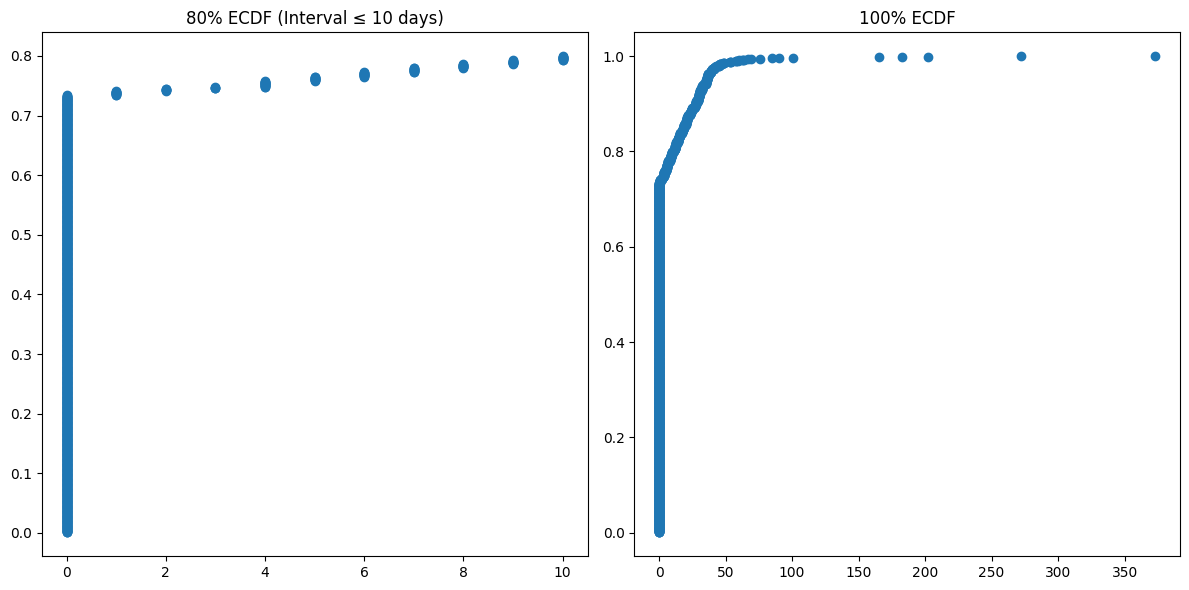

In [287]:
full_kmeans_result = See_KMeans(df=data)  # Basically the entirety of the dataset (not the callable function specific to one category)
full_dbscan_result = See_DBSCAN(df=data)  # Basically the entirety of the dataset (not the callable function specific to one category)

<h2> THOUGHT PROCESS OF MINE FOR GETTING THE SILHOUETTE SCORE AND CHECKING DBSCAN RESULT SPECIFICALLY CROSS CHECKING</h2>

In [280]:
print(full_dbscan_result.columns)
print(full_kmeans_result.columns)

Index(['interval_days', 'ecdf', 'cluster', 'CATEGORY'], dtype='object')
Index(['interval_days', 'ecdf', 'cluster', 'CATEGORY'], dtype='object')


In [ ]:
print(dbscan_valid['cluster'].value_counts())  # Shows how many points remain in each cluster total
print(full_dbscan_result['cluster'].value_counts())


cluster
0    4
Name: count, dtype: int64
cluster
 0    1540
-1       8
Name: count, dtype: int64


In [282]:
for category in categories:
    category_data = full_dbscan_result[full_dbscan_result['CATEGORY'] == category]
    cluster_counts = category_data['cluster'].value_counts()
    print(f"Category: {category}")
    print(cluster_counts)


Category: R03AC12
cluster
 0    21
-1     2
Name: count, dtype: int64
Category: A09AA02
cluster
 0    243
-1      1
Name: count, dtype: int64
Category: A02BC02
cluster
0    3
Name: count, dtype: int64
Category: R03AK07
cluster
0    30
Name: count, dtype: int64
Category: A11CC05
cluster
 0    105
-1      1
Name: count, dtype: int64
Category: A11HA03
cluster
 0    159
-1      1
Name: count, dtype: int64
Category: J01AA08
cluster
0    19
Name: count, dtype: int64
Category: J01FA10
cluster
 0    117
-1      2
Name: count, dtype: int64
Category: R05CB13
cluster
0    76
Name: count, dtype: int64
Category: A05AA02
cluster
0    74
Name: count, dtype: int64
Category: A12AX
cluster
0    10
Name: count, dtype: int64
Category: J01EE01
cluster
0    40
Name: count, dtype: int64
Category: J01XB01
cluster
0    63
Name: count, dtype: int64
Category: B02BA01
cluster
 0    72
-1     1
Name: count, dtype: int64
Category: R03AK08
cluster
0    3
Name: count, dtype: int64
Category: J02AC02
cluster
0    62
Na

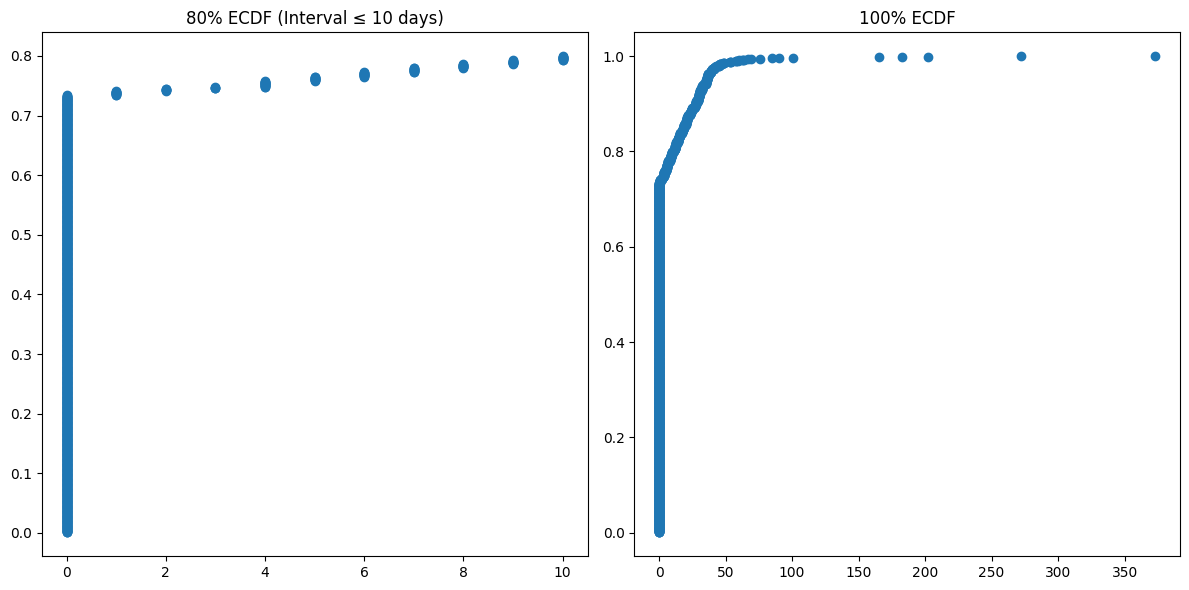

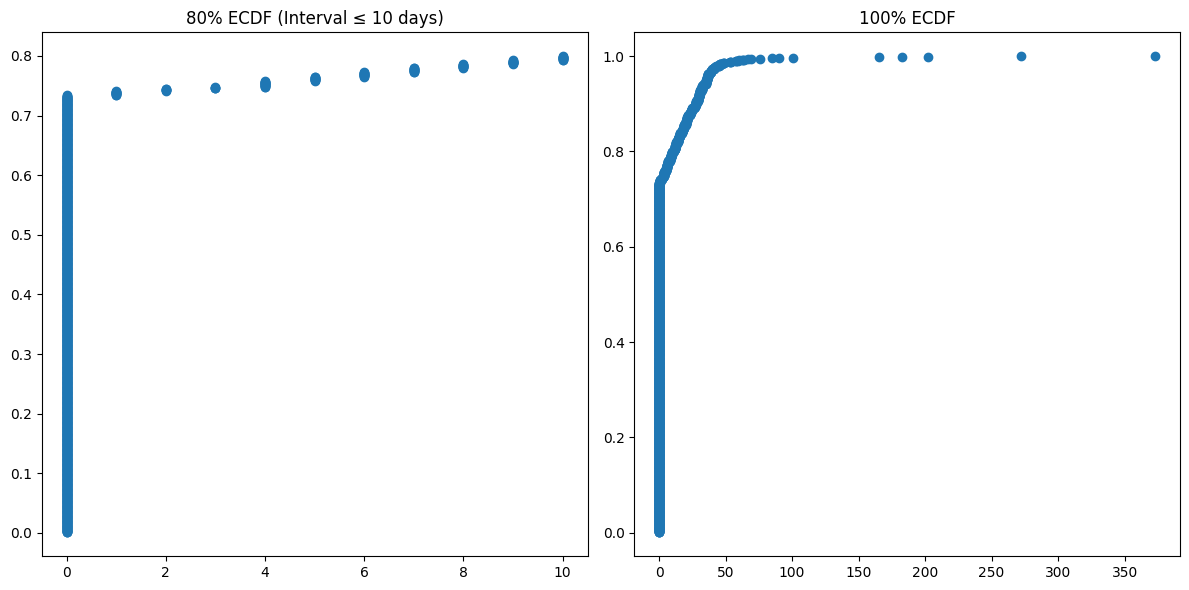

Optimal number of clusters for K-Means: 2 (Silhouette Score: 0.95)
DBSCAN did not form multiple clusters. Silhouette Score cannot be computed.
DBSCAN Silhouette Score: Not Available (only one cluster found)


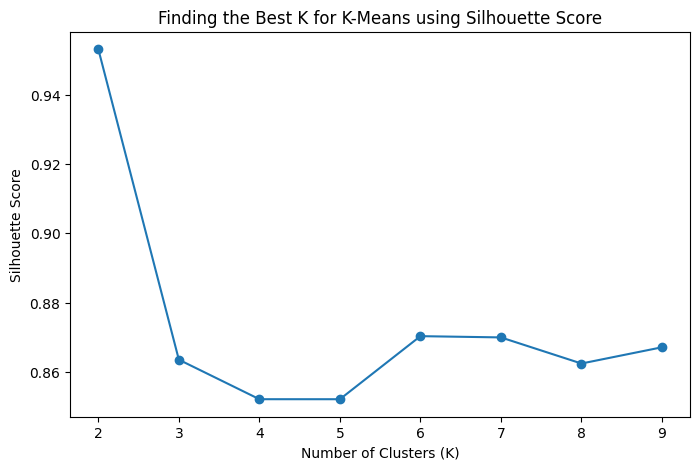

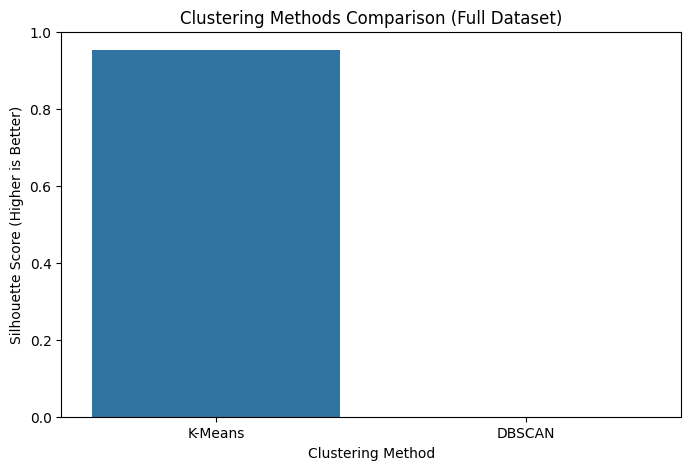

In [279]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
np.random.seed(1234)

# --- RUN K-MEANS & DBSCAN ON FULL DATASET ---
full_kmeans_result = See_KMeans(df=data)  # No category → Full dataset
full_dbscan_result = See_DBSCAN(df=data)  # No category → Full dataset

# --- FIND BEST K FOR K-MEANS ---
scores = []
cluster_range = range(2, 10)  # Trying K values from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
    labels = kmeans.fit_predict(full_kmeans_result[['interval_days']])
    score = silhouette_score(full_kmeans_result[['interval_days']], labels)
    scores.append(score)

# Find the best K (highest silhouette score)
best_k = cluster_range[np.argmax(scores)]
best_k_score = max(scores)  # Highest silhouette score for K-Means
print(f"Optimal number of clusters for K-Means: {best_k} (Silhouette Score: {best_k_score:.2f})")

# --- COMPUTE SILHOUETTE SCORE FOR DBSCAN ---
dbscan_labels = full_dbscan_result['cluster']
dbscan_valid = full_dbscan_result[dbscan_labels != -1]  # Exclude outliers (-1)

# Check if DBSCAN has at least 2 clusters
if len(set(dbscan_valid['cluster'])) > 1:
    dbscan_score = silhouette_score(dbscan_valid[['interval_days']], dbscan_valid['cluster'])
else:
    dbscan_score = None
    print("DBSCAN did not form multiple clusters. Silhouette Score cannot be computed.")

# Print DBSCAN Score
if dbscan_score is not None:
    print(f"DBSCAN Silhouette Score: {dbscan_score:.2f}")
else:
    print("DBSCAN Silhouette Score: Not Available (only one cluster found)")

# --- PLOT: K-MEANS BEST K SELECTION ---
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Finding the Best K for K-Means using Silhouette Score")
plt.show()

# --- PLOT: K-MEANS VS DBSCAN ---
comparison_df = pd.DataFrame({
    'Clustering Method': ['K-Means', 'DBSCAN'],
    'Silhouette Score': [best_k_score, dbscan_score if dbscan_score is not None else 0]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Clustering Method', y='Silhouette Score', data=comparison_df, hue='Clustering Method', legend=False)
plt.title('Clustering Methods Comparison (Full Dataset)')
plt.xlabel('Clustering Method')
plt.ylabel('Silhouette Score (Higher is Better)')
plt.show()
